# LDA for Enron Emails

Installing dependencies

In [1]:
import pandas as pd
import nltk
import re
import warnings
from tqdm import tqdm
import random
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from sklearn.model_selection import train_test_split
import pickle

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# enron_emails_df=pd.read_csv('./data/filter_50krows.csv')
# enron_emails_df=pd.read_csv('../data/finalv1_data.csv')
enron_emails_df=pd.read_csv('../data/email_with_predicted_roles.csv')
enron_emails_df.head()

,From,To,Subject,X-cc,X-bcc,Content,Job_Title,Total_Sentence_Word_Count,From_Names,To_Names,Cleaned_Content,BoW,DateTime
0,richard.shapiro@enron.com,leslie.lawner@enron.com,Re: Talking points about California Gas market,"Christi L Nicolay, Joe Hartsoe, Rebecca W Cant...",X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,"Leslie,after seeing point # 3 in writing , I w...","Vice President, Regulatory Affairs",133,richard shapiro,leslie lawner,leslieafter seeing point 3 writing extremely r...,"['leslieafter', 'seeing', 'point', '3', 'writi...",12 Dec 2000
1,keith.holst@enron.com,k..allen@enron.com,FW: must see,X-bcc:,"X-Folder: \PALLEN (Non-Privileged)\Allen, Phil...","-----Original Message-----\nFrom: \tMarquez, J...",Director,137,keith holst,k allen,original message marquez jose tuesday october ...,"['original', 'message', 'marquez', 'jose', 'tu...",23 Oct 2001
2,john.lavorato@enron.com,k..allen@enron.com,RE: Chase Backtest,X-bcc:,"X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...",no\n\n -----Original Message-----\nFrom: \tAll...,"CEO, Enron America",164,john lavorato,k allen,original message allen phillip k monday decemb...,"['original', 'message', 'allen', 'phillip', 'k...",20 Dec 2001
3,louise.kitchen@enron.com,"wes.colwell@enron.com, georgeanne.hodges@enron...",NETCO,"Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...",The New Year has arrived and we really to fina...,"President, Enron Online",375,louise kitchen,"wes colwell, georgeanne hodges, rob milnthorp",new year arrived finalize lot work regards mov...,"['new', 'year', 'arrived', 'finalize', 'lot', ...",31 Dec 2001
4,louise.kitchen@enron.com,"tim.belden@enron.com, f..calger@enron.com, m.....",Re-start/Integration Planning,"Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...",We have for the last couple of weeks started t...,"President, Enron Online",238,louise kitchen,"tim belden, f calger, m presto",last couple weeks started compile restartinteg...,"['last', 'couple', 'weeks', 'started', 'compil...",27 Dec 2001


To do:

1. remove words less than 3 letters
2. remove number strings

In [4]:
import ast

# Convert string to list
enron_emails_df["BoW"] = enron_emails_df["BoW"].apply(ast.literal_eval)

enron_emails_df["BoW"].head()

0    [leslieafter, seeing, point, 3, writing, extre...
1    [original, message, marquez, jose, tuesday, oc...
2    [original, message, allen, phillip, k, monday,...
3    [new, year, arrived, finalize, lot, work, rega...
4    [last, couple, weeks, started, compile, restar...
Name: BoW, dtype: object

In [5]:
print(type(enron_emails_df["BoW"][0]))

<class 'list'>


In [6]:
def clean_bow(bow_list):
    return [word for word in bow_list if len(word) >= 3 and not any(char.isdigit() for char in word)]



In [7]:
enron_emails_df["cleaned_bow"] = enron_emails_df["BoW"].apply(clean_bow)

In [8]:
enron_emails_df["cleaned_bow"].head()

0    [leslieafter, seeing, point, writing, extremel...
1    [original, message, marquez, jose, tuesday, oc...
2    [original, message, allen, phillip, monday, de...
3    [new, year, arrived, finalize, lot, work, rega...
4    [last, couple, weeks, started, compile, restar...
Name: cleaned_bow, dtype: object

In [9]:
# Step 2: Split into train and test
train_data, test_data = train_test_split(enron_emails_df["cleaned_bow"], test_size=0.2, random_state=42)

In [10]:
print(train_data)

177465    [big, switch, shutting, public, service, elect...
90380     [rao, add, acronym, price, sheet, city, garlan...
19839     [thought, ignored, communications, last, week,...
261512    [note, message, related, new, enhancements, ad...
146210    [dts, show, taking, extra, dts, per, day, show...
                                ...                        
259178    [tom, fine, effective, fairness, depends, view...
365838    [task, assignment, status, completed, task, pr...
131932    [summary, report, showing, following, data, fi...
146867    [made, following, changes, track, pay, transmi...
121958    [credit, approval, requested, shipper, western...
Name: cleaned_bow, Length: 305264, dtype: object


In [11]:
# Step 3: Find best k for LDA using coherence
enron_dictionary = corpora.Dictionary(train_data)
enron_vecs = [enron_dictionary.doc2bow(text) for text in train_data]

In [12]:
print(enron_vecs[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2)]]


In [13]:
# import ast

# # Convert the "BoW" column into an array of arrays
# enron_docs = []
# for row in train_data:
#     enron_docs.append(row)


In [14]:
# import gensim
# enron_dictionary = gensim.corpora.Dictionary(enron_docs)
# enron_vecs = [enron_dictionary.doc2bow(doc) for doc in enron_docs]

# print(enron_vecs[:2])

## Find optimal number of Topics (K)

In [15]:
# Can take a long time to run. In this case we are going to k_max=10.
import datetime
from tqdm import tqdm  # Import tqdm for progress bar
from gensim.models import CoherenceModel

print(datetime.datetime.now())

model_list = []
coherence_values = []
model_topics = []

# Use tqdm to wrap the range for progress tracking
for num_topics in tqdm(range(2, 16, 2), desc="Training LDA Models"):
    enron_lda_x = gensim.models.ldamodel.LdaModel(corpus=enron_vecs, id2word=enron_dictionary, num_topics=num_topics, random_state=123, passes=10, alpha='auto', per_word_topics=True)
    coherencemodel = CoherenceModel(model=enron_lda_x, texts=train_data, dictionary=enron_dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(enron_lda_x)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

print(datetime.datetime.now())

2025-04-07 08:03:36.052971


Training LDA Models:  14%|█▍        | 1/7 [21:20<2:08:05, 1280.88s/it]

#Topics: 2 Score: 0.48290897532256566


Training LDA Models:  29%|██▊       | 2/7 [54:07<2:20:21, 1684.22s/it]

#Topics: 4 Score: 0.5125038841038889


Training LDA Models:  43%|████▎     | 3/7 [1:30:02<2:06:37, 1899.37s/it]

#Topics: 6 Score: 0.5406657111722049


Training LDA Models:  57%|█████▋    | 4/7 [2:06:48<1:41:00, 2020.28s/it]

#Topics: 8 Score: 0.5344184616837504


Training LDA Models:  71%|███████▏  | 5/7 [2:52:41<1:16:09, 2284.63s/it]

#Topics: 10 Score: 0.5153550600370778


Training LDA Models:  86%|████████▌ | 6/7 [4:27:55<57:30, 3450.40s/it]  

#Topics: 12 Score: 0.5788053644969068


Training LDA Models: 100%|██████████| 7/7 [5:27:55<00:00, 2810.78s/it]

#Topics: 14 Score: 0.5722690911814494
2025-04-07 13:31:31.551806


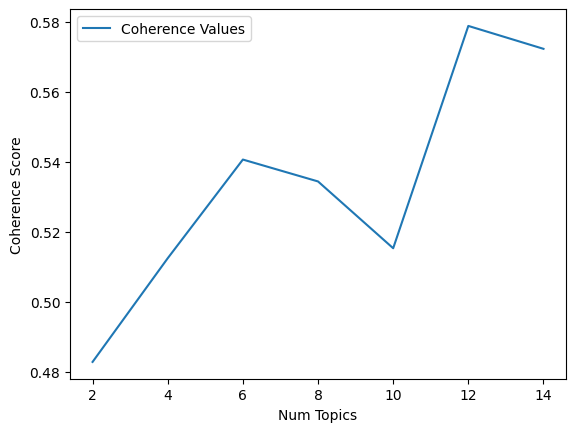

In [16]:
import matplotlib.pyplot as plt

# Use the same range as the loop that generated coherence_values
start = 2
limit = 16
step = 2
x = range(start, limit, step)  # This will match the length of coherence_values

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(["Coherence Values"], loc="best")
plt.show()

## Build the LDA Model

In [17]:
# Number of passes (iterations over the corpus)
num_passes = 10

# Initialize the LDA model
enron_lda = gensim.models.ldamodel.LdaModel(
    corpus=enron_vecs,
    id2word=enron_dictionary,
    num_topics=6,
    passes=1,  # Set passes to 1 for manual looping
    update_every=1,
    per_word_topics=True
)

# Use tqdm to track progress
for i in tqdm(range(num_passes), desc="Training LDA Model"):
    enron_lda.update(enron_vecs)  # Update the model with the corpus

Training LDA Model: 100%|██████████| 10/10 [30:24<00:00, 182.42s/it]


In [26]:
topics = enron_lda.show_topics(6, 30)

for i in range(0,6 ):
    print(topics[i])

(0, '0.014*"said" + 0.013*"power" + 0.010*"energy" + 0.007*"state" + 0.005*"electricity" + 0.005*"california" + 0.005*"new" + 0.005*"gas" + 0.004*"million" + 0.004*"market" + 0.004*"billion" + 0.004*"prices" + 0.003*"companies" + 0.003*"year" + 0.003*"price" + 0.003*"last" + 0.003*"one" + 0.003*"inc" + 0.003*"dow" + 0.003*"jones" + 0.003*"davis" + 0.003*"enrons" + 0.003*"utilities" + 0.003*"percent" + 0.003*"business" + 0.003*"states" + 0.003*"stock" + 0.002*"two" + 0.002*"financial" + 0.002*"news"')
(1, '0.010*"market" + 0.009*"ferc" + 0.009*"california" + 0.008*"final" + 0.006*"power" + 0.006*"capacity" + 0.006*"iso" + 0.005*"schedule" + 0.005*"transmission" + 0.005*"hour" + 0.005*"price" + 0.005*"rate" + 0.005*"jeff" + 0.005*"energy" + 0.005*"customers" + 0.005*"order" + 0.004*"file" + 0.004*"commission" + 0.004*"generation" + 0.004*"gas" + 0.003*"pge" + 0.003*"bill" + 0.003*"load" + 0.003*"comments" + 0.003*"rates" + 0.003*"costs" + 0.003*"variances" + 0.003*"epmi" + 0.003*"utiliti

Topic 0: "Energy Market & State-Level Power Issues"

Topic 1: "Regulatory & Infrastructure (FERC, ISO, Transmission)"

Topic 2: "Energy Trading & Legal Contracts"

Topic 3: "Internal Communications & Personnel"

Topic 4: "Corporate Strategy, Risk, & Operations"

Topic 5: "Casual/Internal Email Chatter"

In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [20]:
# Generate the visuals
visual= gensimvis.prepare(enron_lda, enron_vecs, enron_dictionary)

In [21]:
#Save the output to the html file
pyLDAvis.save_html(visual, "train_enron_topic_viz_6_topics.html")

## Perplexity & Coherence Scores

In [22]:
# Compute Perplexity
perplex= enron_lda.log_perplexity(enron_vecs, total_docs=None) #For LDAModel
  # a measure of how good the model is. lower the better.
print('\nPerplexity for LDAModel: ', perplex)



Perplexity for LDAModel:  -8.80197668614668


In [23]:
# Compute Coherence Score
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=enron_lda, texts=train_data, dictionary=enron_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAModel: ', coherence_lda)


Coherence Score LDAModel:  0.5295519065208484


In [ ]:
# Save model
enron_lda.save("train_enron_lda_model.gensim")



Sample 1: ['today', 'released', 'additional', 'information', 'related', 'party', 'offbalance', 'sheet', 'transactions', 'made', 'information', 'available', 'website', 'form', 'filing', 'securities', 'exchange', 'commission', 'sec', 'information', 'provides', 'details', 'billion', 'charge', 'shareholders', 'equity', 'announced', 'third', 'quarter', 'transactions', 'related', 'charge', 'restatement', 'prior', 'years', 'financial', 'statements', 'reflect', 'reduction', 'shareholders', 'equity', 'consolidation', 'three', 'entities', 'prior', 'year', 'proposed', 'audit', 'adjustments', 'reclassifications', 'special', 'committee', 'appointed', 'board', 'directors', 'review', 'transactions', 'related', 'parties', 'ljm', 'limited', 'partnerships', 'including', 'discussion', 'transactions', 'ljm', 'entities', 'transactions', 'employees', 'information', 'addresses', 'number', 'concerns', 'raised', 'shareholders', 'sec', 'boards', 'new', 'special', 'committee', 'continues', 'review', 'various', 

In [25]:

# Step 5: Evaluate 3 random samples from test data
sample_test_data = random.sample(list(test_data), 3)
for i, doc in enumerate(sample_test_data):
    bow = enron_dictionary.doc2bow(doc)
    topics = enron_lda.get_document_topics(bow)
    print(f"\nSample {i+1}: {doc}")
    print(f"Assigned Topics: {topics}")


Sample 1: ['molly', 'update', 'anshuman', 'see', 'seems', 'transfer', 'issue', 'time', 'put', 'backburner', 'till', 'gets', 'vince', 'relevant', 'section', 'spoke', 'anshuman', 'resistance', 'leaing', 'long', 'time', 'however', 'agreement', 'folks', 'send', 'houston', 'shorter', 'stint', 'dpc', 'budget', 'try', 'finalize', 'leave', 'evening', 'chat', 'vince', 'kaminskihouect', 'sandeep', 'kohlienron_development', 'vince', 'kaminskiect', 'transition', 'research', 'group', 'update', 'vince', 'wanted', 'let', 'know', 'meeting', 'wade', 'cline', 'coo', 'india', 'neil', 'mcgregor', 'president', 'dpc', 'mohan', 'gurunath', 'cfo', 'dpc', 'today', 'though', 'already', 'spoken', 'earlier', 'joining', 'group', 'today', 'became', 'official', 'supported', 'move', 'explained', 'results', 'expected', 'henwood', 'study', 'dpc', 'like', 'pay', 'costs', 'study', 'mentioned', 'maybe', 'tax', 'issues', 'etc', 'need', 'cleared', 'related', 'issues', 'like', 'discuss', 'leave', 'till', 'get', 'houston', '

## Most Dominant Topic

In [ ]:
#Find most dominant topic

import numpy as np

def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    rows = []
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                rows.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break
    sent_topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Text')], axis=1)
    return sent_topics_df

# I choose model_list[2] where the number of topics is 6
df_topic_sents_keywords = format_topics_sentences(ldamodel=enron_lda, corpus=enron_vecs, data=train_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5,0.8738,"one, time, new, us, 000, like, work, get, make...","[traveling, business, meeting, takes, fun, tri..."
1,1,5,0.3430,"one, time, new, us, 000, like, work, get, make...","[randy, send, schedule, salary, level, everyon..."
2,2,6,0.5743,"message, original, 2001, know, meeting, monday...","[following, distribution, updates, phillip, al..."
3,3,7,0.3252,"john, david, sara, kate, paul, l, w, taylorhou...","[1, login, pallen, pw, ke9davis, dont, think, ..."
4,4,1,0.4639,"power, energy, said, market, gas, financial, n...","[phillip, k, allenhouect, 10162000, 0142, buck..."
5,5,0,0.3066,"database, information, agreement, dbcaps97data...","[mr, buckner, delivered, gas, behind, san, die..."
6,6,5,0.8567,"one, time, new, us, 000, like, work, get, make...","[lucy, rentrolls, open, save, rentroll, folder..."
7,7,2,0.5400,"deal, deals, know, need, 1, gas, price, let, 2...","[phillip, k, allenhouect, 10092000, 0216, rich..."
8,8,2,0.5416,"deal, deals, know, need, 1, gas, price, let, 2...","[phillip, k, allenhouect, 10092000, 0200, rich..."
9,9,2,0.3984,"deal, deals, know, need, 1, gas, price, let, 2...","[dave, names, west, desk, members, category, o..."


In [18]:
#Save a model to disk, or reload a pre-trained model
enron_lda_sav=model_list[3] #Or you can save the second best model, model_list[8]

enron_lda_sav.save("model_8Topics")

lda_disk=gensim.models.ldamodel.LdaModel.load("model_8Topics")

In [8]:
lda_disk=gensim.models.ldamodel.LdaModel.load("model_12Topics")